In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
from zipfile import ZipFile
file_name = "PlantVillage.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4304 files belonging to 4 classes.


In [6]:
class_names = dataset.class_names
class_names

['PlantVillage',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 3 2 0 1 2 1 1 2 2 0 0 0 1 0 1 2 1 1 2 2 2 2 1 0 2 2 0]


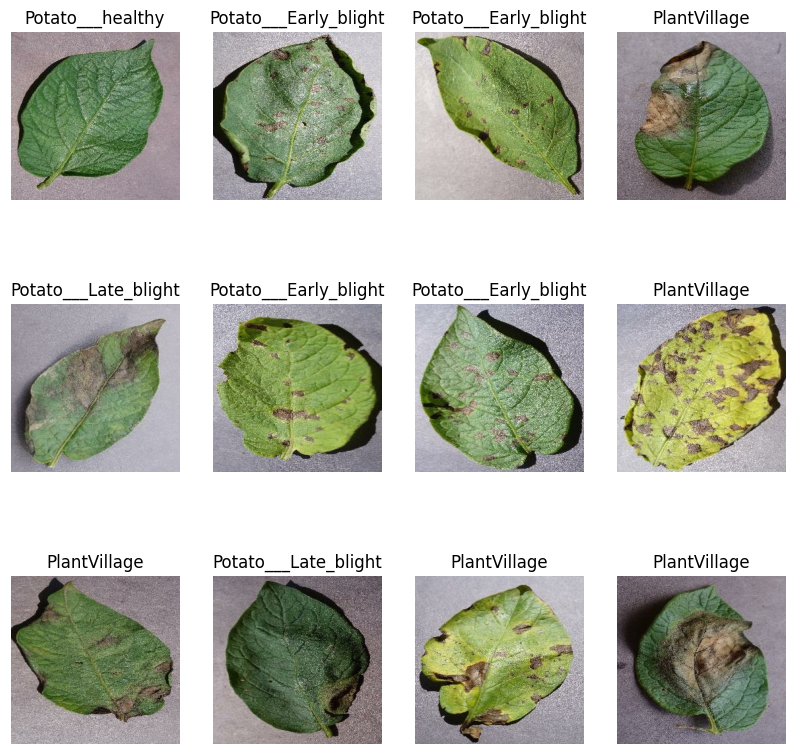

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

135

In [10]:
train_size = 0.8
len(dataset)*train_size

108.0

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

81

In [13]:
val_size=0.1
len(dataset)*val_size

13.5

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

75

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

108

In [19]:
len(val_ds)

13

In [20]:
len(test_ds)

14

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [27]:
from tensorflow.keras import Model

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
  1/108 [..............................] - ETA: 9:22 - loss: 1.1111 - accuracy: 0.2500

InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\traitlets\config\application.py", line 1046, in launch_instance
      app.start()
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Kirankumar Gangoor\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "C:\Users\Kirankumar Gangoor\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "C:\Users\Kirankumar Gangoor\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Kirankumar Gangoor\AppData\Local\Temp\ipykernel_31244\104124643.py", line 6, in <module>
      history = model.fit(
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\losses.py", line 2354, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\backend.py", line 5762, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 3 which is outside the valid range of [0, 3).  Label values: 0 1 1 0 0 1 1 2 2 0 0 2 0 1 0 0 0 2 2 0 2 3 0 0 3 2 1 1 0 0 0 0
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_5437]

In [28]:
scores = model.evaluate(test_ds)

InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\traitlets\config\application.py", line 1046, in launch_instance
      app.start()
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Kirankumar Gangoor\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "C:\Users\Kirankumar Gangoor\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "C:\Users\Kirankumar Gangoor\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Kirankumar Gangoor\AppData\Local\Temp\ipykernel_16180\2814678960.py", line 1, in <module>
      scores = model.evaluate(test_ds)
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\engine\training.py", line 2200, in evaluate
      logs = test_function_runner.run_step(
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\engine\training.py", line 4000, in run_step
      tmp_logs = self._function(dataset_or_iterator)
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\engine\training.py", line 1972, in test_function
      return step_function(self, iterator)
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\engine\training.py", line 1956, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\engine\training.py", line 1944, in run_step
      outputs = model.test_step(data)
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\engine\training.py", line 1852, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\losses.py", line 2354, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\Kirankumar Gangoor\OneDrive\Documents\Tensorflow Object Detection\TFODCourse\tfod\Lib\site-packages\keras\src\backend.py", line 5762, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 3 which is outside the valid range of [0, 3).  Label values: 2 1 0 1 2 1 0 0 3 1 1 2 2 1 3 2 2 0 2 1 2 2 2 1 2 2 0 0 0 0 0 1
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_test_function_3383]

In [ ]:
scores


[0.06790542602539062, 0.97265625]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

50

In [ ]:
history.history['loss'][:5]

[0.8862157464027405,
 0.6600598096847534,
 0.4992619752883911,
 0.38667958974838257,
 0.27293604612350464]

In [ ]:
from tensorflow.keras import Model

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

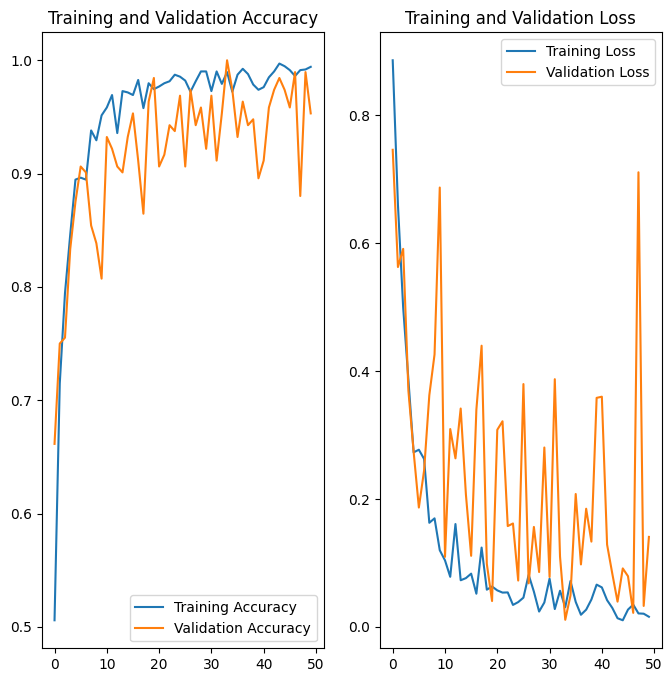

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Early_blight


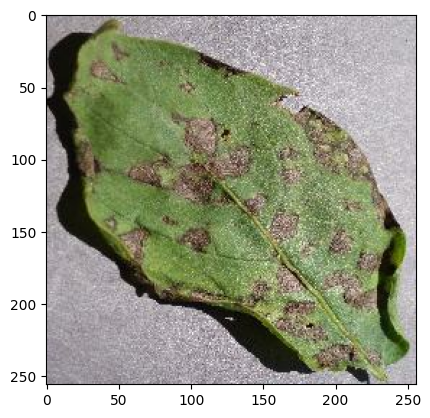

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 58ms/step


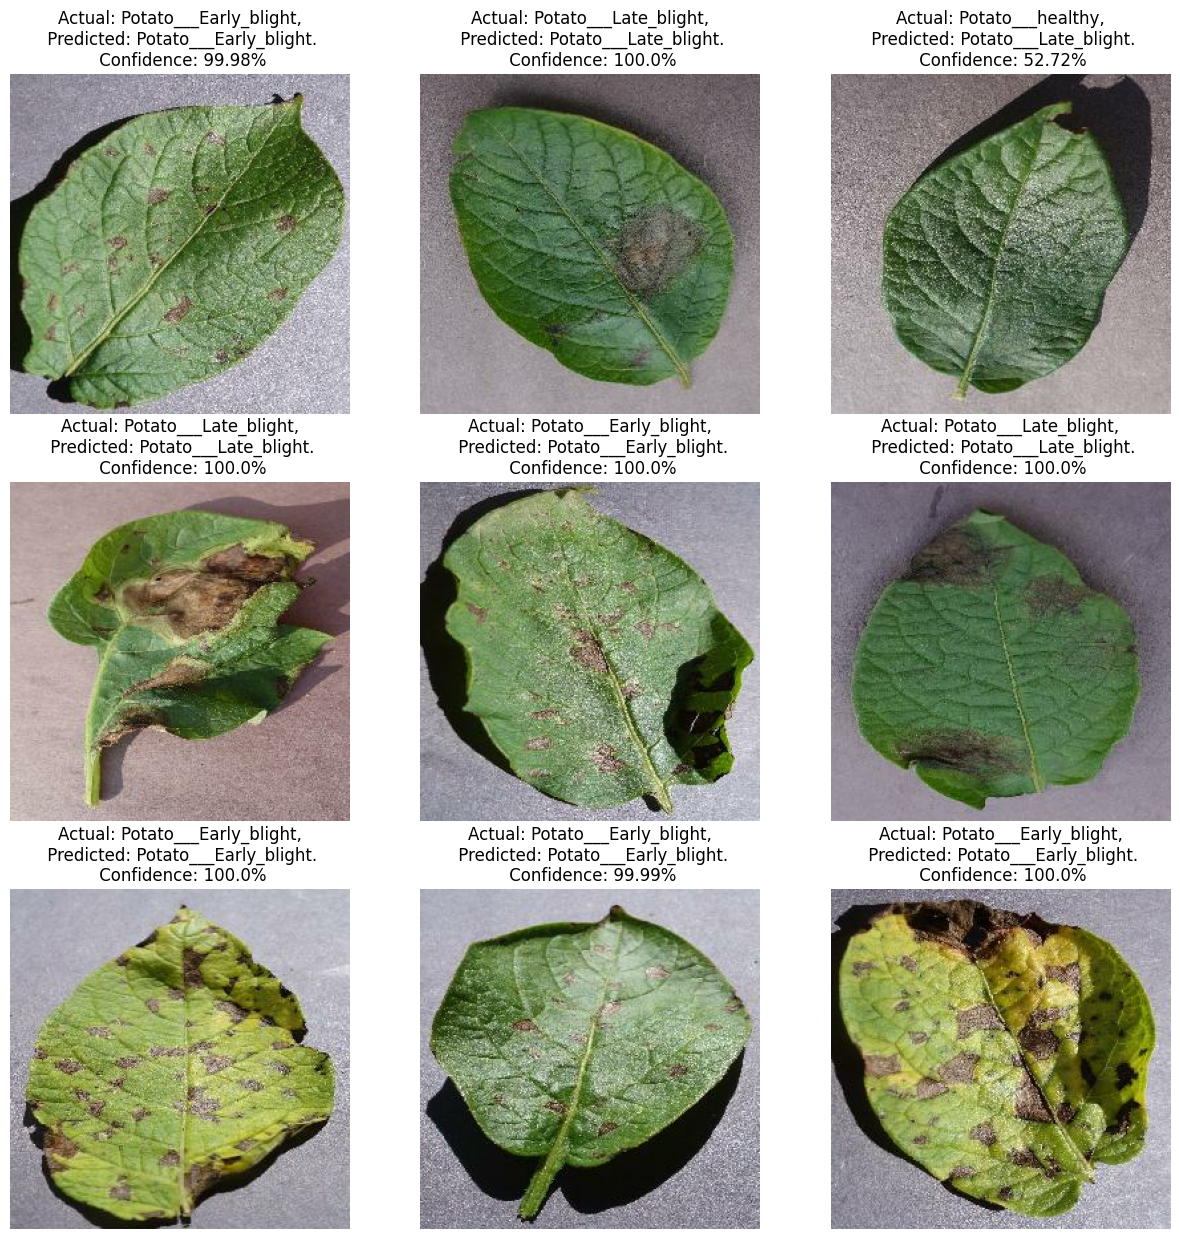

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")